<a href="https://colab.research.google.com/github/1dgog/reto_opticaf2008/blob/main/codigo_optica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diseño de un escáner 3D

Mariana Zaldivar, Fernanda Bolivar, Javier de Golferichs




Cámara Nikon D3100

Resolución del proyector: 1080 x 720


Proyección de las franjas: 702.4 pixeles x 462.6 pixeles


ángulo de donde tomamos las fotos:  22.04 grados
(el proyector está en el eje óptico)


proyector a hoja: 91.4 cm
proyector a vaso: 86.9 cm

cámara a proyector: 37 cm 


Hoja tamaño carta (dimensión) = 21.59 cm x 27.94 cm


cada franja es de máximo a máximo ( una onda completa)
Cuando se utiliza 15: 18.25 franjas en la hoja

periodo= 0.653 onda /cm


Se hace la conexión con google drive fijando el directorio donde se encuentran las imágenes

In [ ]:
%%capture
from google.colab import drive
drive.mount("/content/gdrive")
!pwd
#put your own path in google drive
%cd "/content/gdrive/MyDrive/fotos_reto_optica"
!ls

Carga de librerías

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from skimage import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase
import math
import pandas as pd

import pylab
from google.colab import files
from PIL import Image

from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.ndimage import gaussian_filter
from numpy import savetxt

Se forma el patrón de interferencia, el cual se proyectará sobre una cartulina en el laboratorio de óptica, cuidando que no haya cambios en la iluminación del cuarto.

In [ ]:
I1 = 4; I2 = 4;
N = 2^10;
aux = np.arange(-N/2-1, N/2, 1)*2/N;
x = 20*2*math.pi*aux; y = x;
xv, yv = np.meshgrid(x, y)
delta_phase = 0;
#I=I1+I2+math.sqrt(I1*I2)*math.cos(xv-(delta_phase));

Ya tomadas las [fotografías](https://https://drive.google.com/drive/folders/1j6wbByYjw3jDeyci0M4YPTovC9zvil_D?usp=share_link), estas se importan y deben ser [recortadas](https://https://www.geeksforgeeks.org/python-pil-image-crop-method/) (el tamaño original de las imágenes es de 4608*3072). En caso de que sea conveniente cambiar el contraste.
El paso de las franjas es de 0, pi/2, pi, 3pi/2 y 2pi.

In [ ]:
#CON 15 FRANJAS

# con vaso
im1_c = Image.open('DSC_0007.JPG');
im2_c = Image.open('DSC_0008.JPG');
im3_c = Image.open('DSC_0009.JPG');
im4_c = Image.open('DSC_0010.JPG');
im5_c = Image.open('DSC_0011.JPG');
# sin vaso
im1_s = Image.open('DSC_0012.JPG');
im2_s = Image.open('DSC_0013.JPG');
im3_s = Image.open('DSC_0014.JPG');
im4_s = Image.open('DSC_0015.JPG');
im5_s = Image.open('DSC_0016.JPG');

# Dimensiones para recortar la imagen 
left = 155
top = 3072 / 4
right = 2800
bottom = 3 * 3072 / 4


In [ ]:
#CON 20 FRANJAS

# con vaso
im1_s = Image.open('DSC_0018.JPG');
im2_s = Image.open('DSC_0020.JPG');
im3_s = Image.open('DSC_0021.JPG');
im4_s = Image.open('DSC_0022.JPG');
im5_s = Image.open('DSC_0023.JPG');
# sin vaso
im1_c = Image.open('DSC_0024.JPG');
im2_c = Image.open('DSC_0025.JPG');
im3_c = Image.open('DSC_0026.JPG');
im4_c = Image.open('DSC_0027.JPG');
im5_c = Image.open('DSC_0028.JPG');

left = 155
top = 3072 / 5
right = 2800
bottom = 4 * 3072 / 5


Se hace el recorte de la imágen usando crop de la librería PIL. Luego de esto se conviere a escala de grises. Finalmente se convierte de imagen a un arreglo y se normaliza a valores de 0 a 1

In [ ]:

# crop: corta la imagen, convert('L') lo convierte a escala de grises, np.array 
#lo hace matriz y. se normaliza dividiendolo entre 255 (por la escala de color)

# con vaso
im1_con = np.array(im1_c.crop((left, top, right, bottom)).convert('L'))/255
im2_con = np.array(im2_c.crop((left, top, right, bottom)).convert('L'))/255
im3_con = np.array(im3_c.crop((left, top, right, bottom)).convert('L'))/255
im4_con = np.array(im4_c.crop((left, top, right, bottom)).convert('L'))/255
im5_con = np.array(im5_c.crop((left, top, right, bottom)).convert('L'))/255

# sin vaso
im1_sin = np.array(im1_s.crop((left, top, right, bottom)).convert('L'))/255
im2_sin = np.array(im2_s.crop((left, top, right, bottom)).convert('L'))/255
im3_sin = np.array(im3_s.crop((left, top, right, bottom)).convert('L'))/255
im4_sin = np.array(im4_s.crop((left, top, right, bottom)).convert('L'))/255
im5_sin = np.array(im5_s.crop((left, top, right, bottom)).convert('L'))/255

Se hace el calculo de la fase envuelta con y sin el objeto así como de la resta de las fases envueltas.
También, se hace el cálculo de las fases desenvueltas, con y sin el objeto, así como el desenvolvimiento de la resta de fase.
Se usa la [función de desenvolvimiento](https://scikit-image.org/docs/stable/auto_examples/filters/plot_phase_unwrap.html) de la librería skimage

In [ ]:
# fase envuelta

fase_con = np.arctan2(-(im2_con-im4_con), (im1_con-im3_con));
fase_sin = np.arctan2(-(im2_sin-im4_sin), (im1_sin-im3_sin));
print(np.min(fase_sin))
fase_con = fase_con + np.pi;
fase_sin = fase_sin + np.pi;
print(np.min(fase_sin))
resta_fase = fase_con - fase_sin;

-3.141592653589793
0.0


In [ ]:
savetxt('fase_envuelta_con.csv', fase_con, delimiter=',')
savetxt('fase_envuelta_sin.csv', fase_sin, delimiter=',')
savetxt('fase_envuelta_resta.csv', resta_fase, delimiter=',')

-3.141592653589793
0.0


<Figure size 640x480 with 0 Axes>

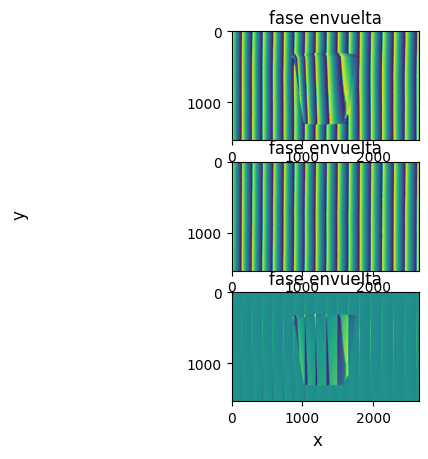

<Figure size 640x480 with 0 Axes>

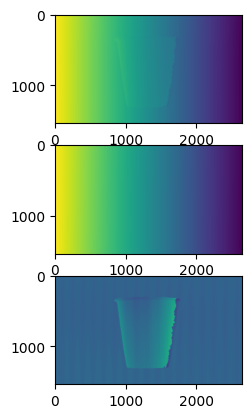

In [ ]:
# fase envuelta

fase_con = np.arctan2(-(im2_con-im4_con), (im1_con-im3_con));
fase_sin = np.arctan2(-(im2_sin-im4_sin), (im1_sin-im3_sin));
resta_fase = fase_con - fase_sin;
print(np.min(fase_sin))
plt.figure()
f, axarr = plt.subplots(3,1)
axarr[0].set(title='fase envuelta')
axarr[1].set(title='fase envuelta')
axarr[2].set(title='fase envuelta')
f.supxlabel('x')
f.supylabel('y')

fase_con = fase_con + np.pi;
fase_sin = fase_sin + np.pi;
print(np.min(fase_sin))

axarr[0].imshow(fase_con);
axarr[1].imshow(fase_sin);
axarr[2].imshow(resta_fase);

# fase desenvuelta

image_unwrapped_con = unwrap_phase(fase_con);
image_unwrapped_sin = unwrap_phase(fase_sin);
image_unwrapped = image_unwrapped_con - image_unwrapped_sin; # resta de fase desenvuelta

plt.figure()
f, axarr = plt.subplots(3,1)

axarr[0].imshow(image_unwrapped_con)
axarr[1].imshow(image_unwrapped_sin)
axarr[2].imshow(image_unwrapped)

In [ ]:
savetxt('fase_des_con.csv', image_unwrapped_con, delimiter=',')
savetxt('fase_des_sin.csv', image_unwrapped_sin, delimiter=',')
savetxt('fase_des_resta.csv', image_unwrapped, delimiter=',')

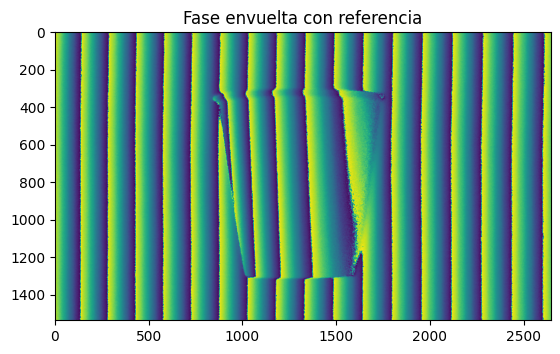

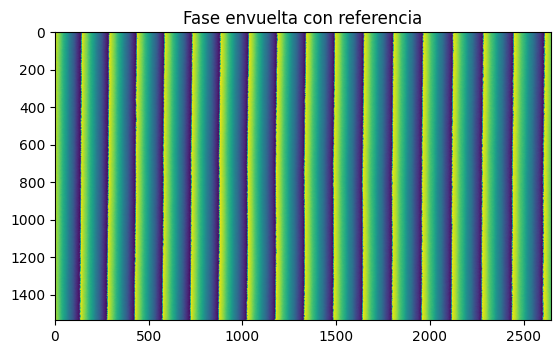

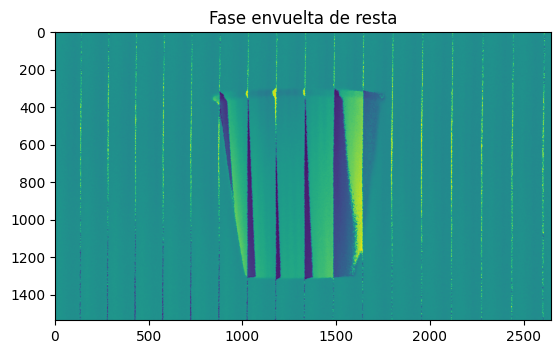

In [ ]:
plt.figure()
plt.imshow(fase_con); plt.title('Fase envuelta con referencia');
plt.figure()
plt.imshow(fase_sin); plt.title('Fase envuelta sin referencia');
plt.figure()
plt.imshow(resta_fase); plt.title('Fase envuelta de resta');

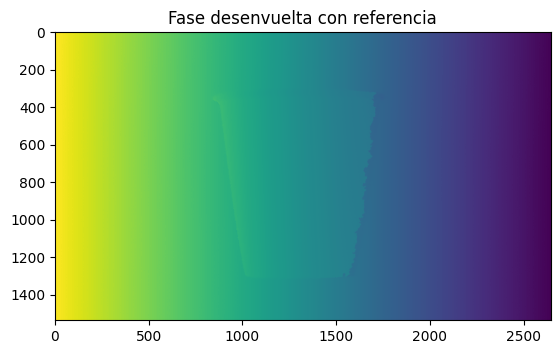

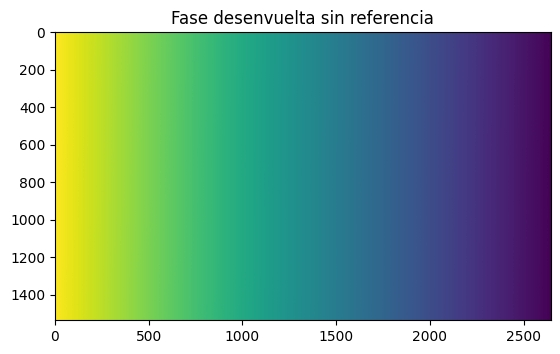

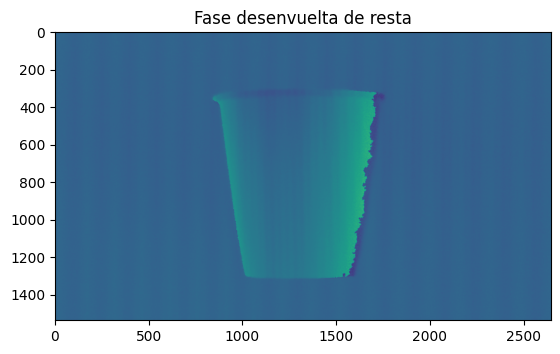

In [ ]:
plt.figure()
plt.imshow(image_unwrapped_con); plt.title('Fase desenvuelta con referencia');
plt.figure()
plt.imshow(image_unwrapped_sin); plt.title('Fase desenvuelta sin referencia');
plt.figure()
plt.imshow(image_unwrapped); plt.title('Fase desenvuelta de resta');

Graficar perfil del vaso, un recorte, 

In [ ]:
#Se g
X = np.arange(0, 2645, 1)
Y = np.arange(0, 1536, 1) # cambiar esto a 1536 para 15 franjas y 1844 cuando son 20
X, Y = np.meshgrid(X, Y)
print(Z.shape)
Z = abs(image_unwrapped)
#Z = gaussian_filter(Z, sigma=1)

ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, Z)
ax.view_init(30, 90)

plt.show()


NameError: ignored

Intento de condición para subir el vaso

In [ ]:
pd.DataFrame(image_unwrapped).to_csv('image_unwrapped.csv')

In [ ]:
#image_unwrapped = np.where(image_unwrapped > 25, 25, image_unwrapped)
#image_unwrapped = np.where(image_unwrapped < 24.8, image_unwrapped+25, image_unwrapped)
#image_unwrapped = np.where(image_unwrapped > 1.3, (6-image_unwrapped), image_unwrapped)

[[25.15318828 24.99714041 25.00672555 ... 24.97523112 24.92958731
  24.93083539]
 [25.01504108 25.0347822  25.00987069 ... 24.9874344  24.96329123
  24.97912865]
 [24.8342423  24.93583134 24.93556151 ... 25.118289   24.96620493
  24.98274719]
 ...
 [25.03258563 25.05837494 24.95392718 ... 24.99290603 25.03224274
  25.00121247]
 [24.99917521 25.08240759 24.99245583 ... 24.92744528 24.87472419
  24.8432134 ]
 [25.0075761  25.10503518 25.05745844 ... 24.95042429 24.84289474
  24.84588305]]
25.0


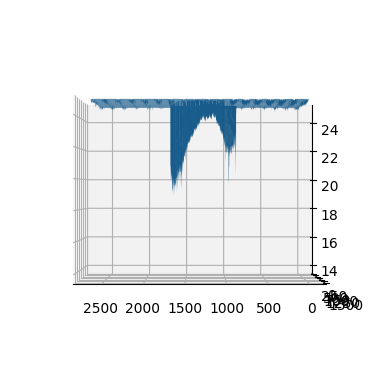

In [ ]:
X = np.arange(0, 2645, 1)
Y = np.arange(0, 1536, 1)
X, Y = np.meshgrid(X, Y)
Z = abs(image_unwrapped)
print(Z)
Z = np.where(Z > 25, 25, Z)
print(np.max(Z))
#Z = np.where(Z == 25, 0, Z)

ax = plt.axes(projection='3d')

ax.plot_surface(X, Y, Z)
ax.view_init(0, 90)

plt.show()

In [ ]:
alt = (Z/2*np.pi)*(1/3)*(91/37)

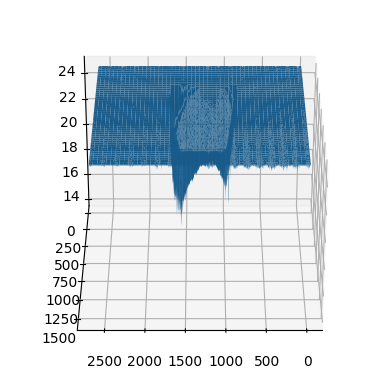

In [ ]:
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z)
ax.view_init(30, 90)